<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/concat_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
import os
import re
import copy

import math
from typing import Optional
import transformers


import torch
import torch.utils.checkpoint as checkpoint
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW, DataCollatorWithPadding
from tensorflow.keras.layers import GlobalAveragePooling1D

import pickle
import re
from transformers import TrainingArguments, AutoConfig, AutoModelForTokenClassification, DataCollatorForTokenClassification

In [5]:
df = pd.read_csv('train.csv')
df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)

label_cols = df.columns[2:]
pred_col_list = ['transformed_pred_' + col for col in label_cols]

orig_df = copy.deepcopy(df)
split = (0.8, 0.2)
splits = np.multiply(len(orig_df), split).astype(int)
df_train, df_test = orig_df[ : splits[0]], orig_df[splits[0] : ]
y_test = np.array(df_test[label_cols], dtype = "float32")


orig_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
MAX_LEN = 128

learning_rate = 1e-5
dropout = .1
epochs = 1
batch_size = 4

In [7]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis = 1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis = -1, keepdims = True)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


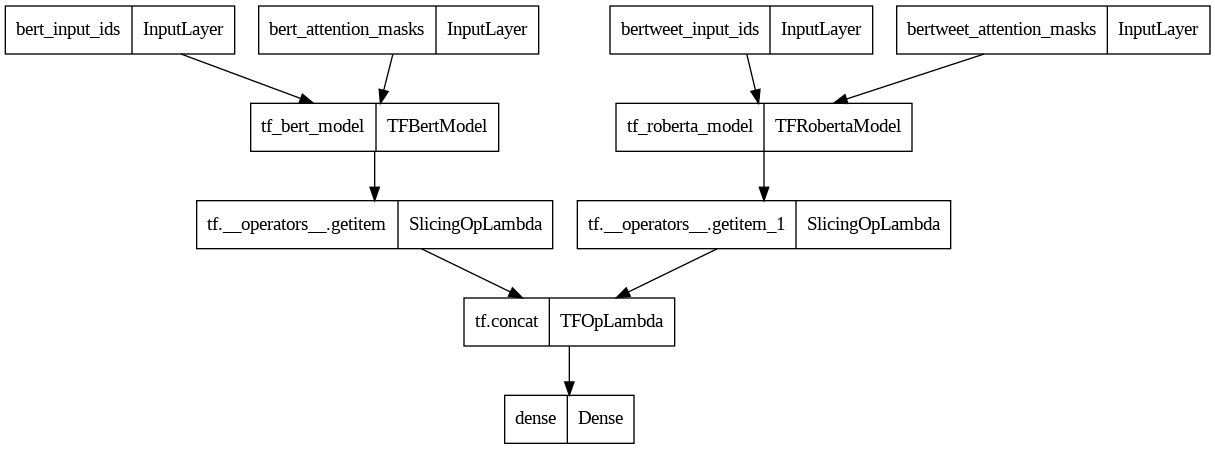

In [8]:
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import TFBertModel, BertTokenizer
from transformers import TFAutoModel, AutoModel, AutoTokenizer

ROBERTA_MODEL_CHKPT = "roberta-base"
BERT_MODEL_CHKPT = "bert-base-cased"
BERTWEET_MODEL_CHKPT = "vinai/bertweet-base"

bert_model = TFBertModel.from_pretrained(BERT_MODEL_CHKPT)  
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_CHKPT)

#roberta_model = TFBertModel.from_pretrained(ROBERTA_MODEL_CHKPT)  
#roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_CHKPT)

bertweet_model = TFAutoModel.from_pretrained(BERTWEET_MODEL_CHKPT)
bertweet_tokenizer = AutoTokenizer.from_pretrained(BERTWEET_MODEL_CHKPT)

bert_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bert_input_ids')
bert_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bert_attention_masks')

#roberta_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'roberta_input_ids')
#roberta_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'roberta_attention_masks')

bertweet_input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bertweet_input_ids')
bertweet_attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'bertweet_attention_masks')

pretrained_bert_transformer = bert_model([bert_input_ids, bert_attention_masks])
#pretrained_roberta_transformer = roberta_model([roberta_input_ids, roberta_attention_masks])
pretrained_bertweet_transformer = bertweet_model([bertweet_input_ids, bertweet_attention_masks])

cls_token_bert = pretrained_bert_transformer[0][:, 0, :]
#cls_token_roberta = pretrained_roberta_transformer[0][:, 0, :]
cls_token_bertweet = pretrained_bertweet_transformer[0][:, 0, :]

cls_token_concatenated = tf.concat([cls_token_bert, 
                                    #cls_token_roberta, 
                                    cls_token_bertweet
                                   ], 
                                   0
                                  )

output = tf.keras.layers.Dense(6)(cls_token_concatenated)
concat_model = tf.keras.models.Model(inputs = [bert_input_ids, bert_attention_masks, 
                                               #roberta_input_ids, roberta_attention_masks, 
                                               bertweet_input_ids, bertweet_attention_masks,], outputs = output)
concat_model.compile(tf.keras.optimizers.Adam(learning_rate), loss = MCRMSE, metrics = MCRMSE)

tf.keras.utils.plot_model(concat_model, 
                              #to_file='model_structure.png', 
                              #show_shapes = True,
                              show_layer_names = True)

In [22]:
def text_encode(texts, tokenizer_list, max_len):
    
    bert_input_ids = []
    bert_attention_masks = []

    bertweet_input_ids = []
    bertweet_attention_masks = []

    bert_tokenizer = tokenizer_list[0]
    bertweet_tokenizer = tokenizer_list[1]

    for text in texts:
        bert_tokens = bert_tokenizer.batch_encode_plus(text,
                                                  padding='max_length',
                                                  max_length=max_len, 
                                                  add_special_tokens = True,
                                                  return_attention_mask=True,
                                                  return_tensors="tf",
                                                  truncation=True)
        bert_input_ids.append(bert_tokens['input_ids'])
        bert_attention_masks.append(bert_tokens['attention_mask'])

        bertweet_tokens = bertweet_tokenizer.batch_encode_plus(text,
                                                  padding='max_length',
                                                  max_length=max_len, 
                                                  add_special_tokens = True,
                                                  return_attention_mask=True,
                                                  return_tensors="tf",
                                                  truncation=True)
        bertweet_input_ids.append(bertweet_tokens['input_ids'])
        bertweet_attention_masks.append(bertweet_tokens['attention_mask'])

    print(len(bert_input_ids), len(bertweet_input_ids), len(bert_attention_masks), len(bertweet_attention_masks))
    return [bert_input_ids, bert_attention_masks, bertweet_input_ids, bertweet_attention_masks]


In [23]:
class EssayDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 tokenizer_list,
                 df,
                 max_len,
                 batch_size=8,
                 shuffle=True):
        
        self.tokenizer_list = tokenizer_list
        self.bert_tokenizer = self.tokenizer_list[0]
        self.bertweet_tokenizer = self.tokenizer_list[1]
        self.df = df
        self.n_examples = len(df)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_len = max_len
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # Return the number of batches in the full dataset
        return (np.ceil(len(self.df) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        batch_x = self.df[idx * self.batch_size : (idx+1) * self.batch_size]['full_text'].values.astype(str).tolist()
        batch_y = np.array(self.df[idx * self.batch_size : (idx+1) * self.batch_size][label_cols], dtype = "float32")
        #self.df[idx * self.batch_size : (idx+1) * self.batch_size][label_cols].values
        print(batch_x)
        #full_text = batch_x[['full_text']].values.astype(str).tolist()
        #labels = batch_y[label_cols].values
        
        batch_encoded_data = text_encode(
            batch_x,
            self.tokenizer_list,
            self.max_len
        )
        print(batch_y)
        return batch_encoded_data, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

train_data_generator = EssayDataGenerator([bert_tokenizer,bertweet_tokenizer],df_train, 128)

In [12]:
!mkdir model_checkpoints

In [13]:
checkpoint_dir = '/content/model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [24]:
hist = concat_model.fit(train_data_generator[0], train_data_generator[1], epochs=5,
                        steps_per_epoch = int(df_train.shape[0] // batch_size),
          callbacks=[model_checkpoint_callback])

["I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.  The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.  most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go take

ValueError: ignored

In [ ]:
hist